# VisiumHD: From 16 µm to 2 µm resolution

In this tutorial we will look at a colorectal cancer (CRC) sample profiled using VisiumHD. The data is available from the 10X website (see [here](https://www.10xgenomics.com/datasets/visium-hd-cytassist-gene-expression-libraries-of-human-crc)).

To follow along you will need to download the data and install some additional packages;
`scanpy` and `spatialdata_io`.

First we will load all the packages that we need.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import scanpy as sc
import spatialdata_io

import sainsc

In [ ]:
# make sure you adjusted the path to where you downloaded the data
visium_path = Path("path/to/Visium_HD_Human_Colon_Cancer")

unbinned_path = visium_path / "binned_outputs" / "square_002um"

In [3]:
# random seed for reproducibility
seed = 42

## Cell typing of 16 µm bins

First we will generate cell type signature based on the 16 µm bins VisiumHD. Theoretically this should also work when using the 8 µm bins or segmentation-based cells. The signatures are then later used to map the cell types to the original 2 µm resolution.

This whole section can be replaced by your favorite single-cell workflow. We will follow a simple workflow here as this is not the main purpose of this tutorial.

In [4]:
# load the data
spatial_visium = spatialdata_io.visium_hd(visium_path, bin_size=16)

adata_16um = spatial_visium.tables["square_016um"]

# for good practice we will switch from gene_name to gene_ids
adata_16um.var = adata_16um.var.reset_index(names="gene_name").set_index("gene_ids")

/dh-projects/ag-ishaque/analysis/muellni/envs/sainsc_dev/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/tmp/ipykernel_3262877/2044066938.py:2: UserWarning: No full resolution image found. If incorrect, please specify the path in the `fullres_image_file` parameter when calling the `visium_hd` reader function.
  spatial_visium = spatialdata_io.visium_hd(visium_path, bin_size=16)


First we will calculate some QC-metrics ...

In [5]:
sc.pp.calculate_qc_metrics(adata_16um, inplace=True, log1p=False)

... and have a first look what our sample looks like.

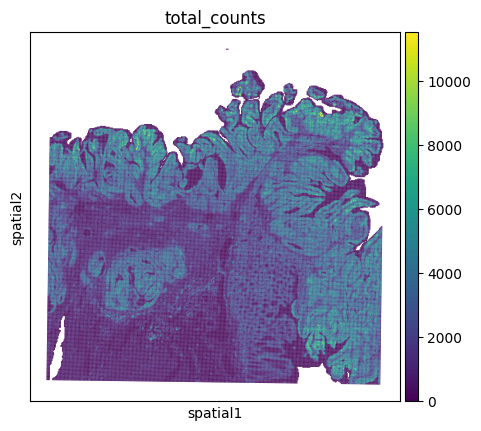

In [6]:
sc.pl.spatial(adata_16um, color="total_counts", spot_size=75)

Now we apply our favorite workflow to find clusters/cell types. Remember that you can adjust the processing here to your liking! For example you could switch to spatially variable genes instead of highly variable.

In [7]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

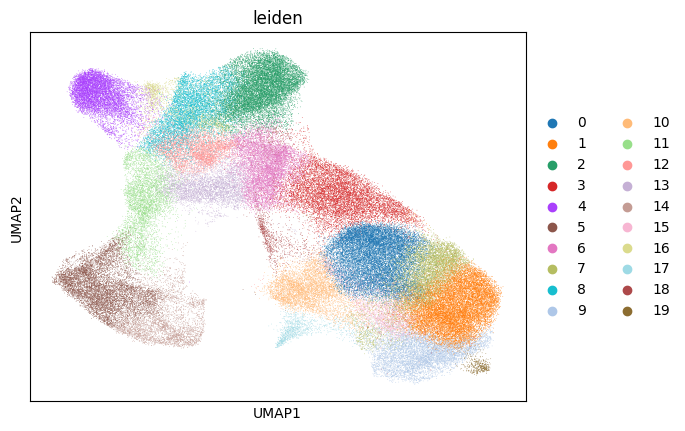

In [8]:
# filtering
sc.pp.filter_genes(adata_16um, min_cells=20)
sc.pp.filter_cells(adata_16um, min_counts=200)

# HVGs
sc.pp.highly_variable_genes(adata_16um, n_top_genes=2_000, flavor="seurat_v3")

# pre-processing
sc.pp.normalize_total(adata_16um, target_sum=1e4)
sc.pp.log1p(adata_16um)
sc.pp.pca(adata_16um, random_state=seed)

sc.pp.neighbors(adata_16um, random_state=seed)

# clustering
sc.tl.umap(adata_16um, random_state=seed)
sc.tl.leiden(adata_16um, random_state=seed)

sc.pl.umap(adata_16um, color="leiden")

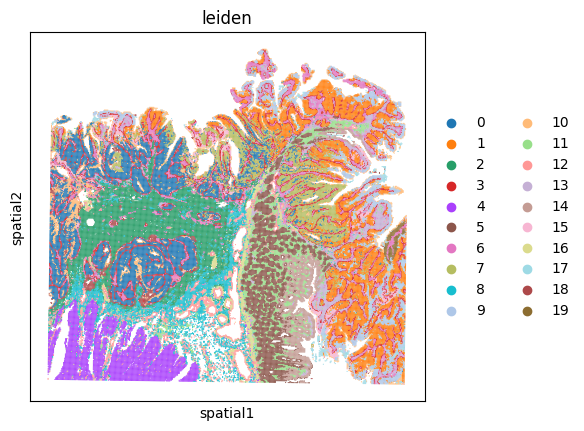

In [9]:
sc.pl.spatial(adata_16um, color="leiden", spot_size=75)

## Generating cell type signatures

Now we are ready to generate the cell type signatures.

The only thing to keep in mind if you don't follow the workflow above is that the signatures should be non-negative i.e. they should not be generated from z-scores or Pearson residuals, etc. which does not mean that you can't use these methods to do the cell typing just make sure to use the log-transformed counts to calculate the signatures.

Here, we will only use the highly variable genes.

In [10]:
signatures = sainsc.utils.celltype_signatures(
    adata_16um[:, adata_16um.var["highly_variable"]]
)

In [11]:
# ensure the same colors for scanpy and the plots used later
cmap = dict(
    zip(adata_16um.obs["leiden"].cat.categories, adata_16um.uns["leiden_colors"])
)

## Subcellular cell typing

Now we are ready to process the data with `sainsc`. First, we will need to load it.

In [12]:
visium_hd = sainsc.io.read_VisiumHD(unbinned_path, n_threads=16)

visium_hd

LazyKDE (16 threads)
    genes: 18072
    shape: (3350, 3350)
    resolution: 2000.0 nm / px

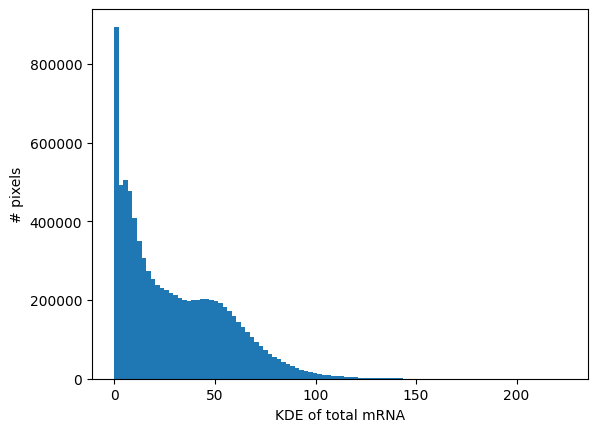

In [13]:
visium_hd.gaussian_kernel(4, unit="um")
visium_hd.calculate_total_mRNA_KDE()

_ = visium_hd.plot_KDE_histogram(bins=100)

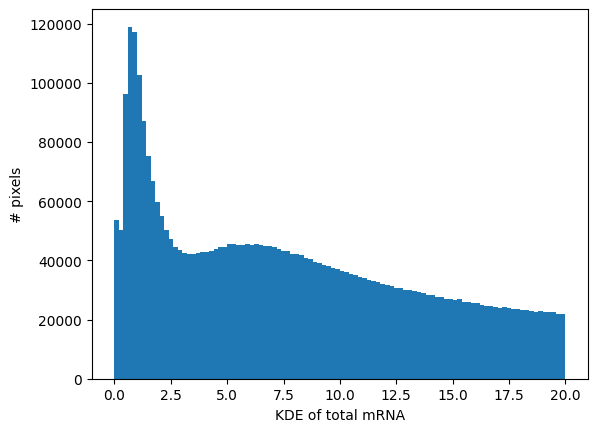

In [14]:
_ = visium_hd.plot_KDE_histogram(bins=100, range=(0, 20))

In [28]:
visium_hd.filter_background(4.5)

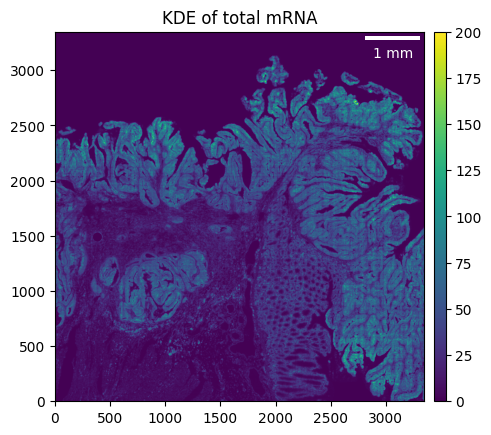

In [16]:
_ = visium_hd.plot_KDE(im_kwargs={"vmax": 200})

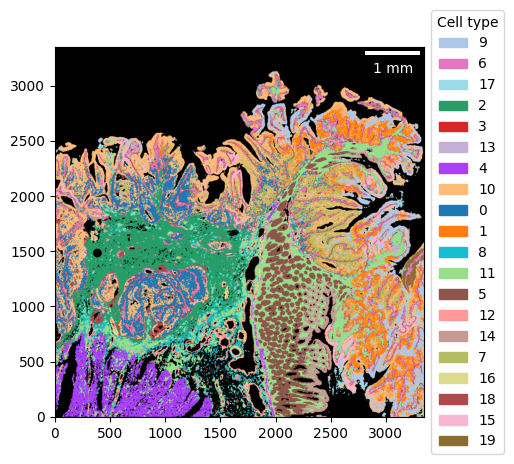

In [17]:
visium_hd.assign_celltype(signatures, log=True)

_ = visium_hd.plot_celltype_map(cmap=cmap)

### Compare bins to 2 µm resolution

To compare the cell typing we will plot the unbinned and binned data next to each other.

First lets get the images for the cell typing of the unbinned data. 

In [29]:
ctmap = visium_hd.plot_celltype_map(cmap=cmap, return_img=True)
kde = visium_hd.total_mRNA_KDE.T

For the bins we will need to generate a comparable image.

In [ ]:
from math import ceil

import numpy as np
from matplotlib.colors import to_rgb
from scipy.sparse import coo_array

background = "black"

cmap_ls = [cmap[celltype] for celltype in adata_16um.obs["leiden"].cat.categories]
color_map = np.array([to_rgb(c) for c in [background] + cmap_ls])


celltype = adata_16um.obs["leiden"].cat.codes
x = adata_16um.obs["array_row"]
y = adata_16um.obs["array_col"]

# +1 for background
ctmap_16um = coo_array(
    (celltype + 1, (x, y)), shape=[ceil(i / 8) for i in visium_hd.shape]
)
ctmap_16um = np.take(color_map, ctmap_16um.toarray(), axis=0)

Now we are ready to compare the results. We will also include the KDE as it gives us an orientation of what the tissue looks like. 

In [25]:
from matplotlib_scalebar.scalebar import ScaleBar


def plot_ctmaps(
    ctmap1, ctmap2, /, rna=None, *, scale: int = 8, size: float = 3, **kwargs
):
    n_ax = 2 if rna is None else 3

    fig, axs = plt.subplots(1, n_ax, figsize=(n_ax * size, size))

    i = 0
    if rna is not None:
        _ = axs[i].imshow(rna, origin="lower")
        axs[i].set(title="RNA")
        i += 1
    _ = axs[i].imshow(ctmap1, origin="lower")
    axs[i].set(title="2 µm")
    _ = axs[i + 1].imshow(ctmap2, origin="lower")
    axs[i + 1].set(title=f"bin{scale}")

    axs[0].add_artist(ScaleBar(2, units="um", **kwargs))

    for ax in axs:
        ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    fig.tight_layout()


def subset_ctmaps(ctmap1, ctmap2, /, x, y, *, rna=None, scale: int = 8):
    def subset(ctmap, x, y):
        return ctmap[y[0] : y[1], x[0] : x[1]]

    x_wo_bins = [i * scale for i in x]
    y_wo_bins = [i * scale for i in y]

    ctmap2 = subset(ctmap2, x, y)
    ctmap1 = subset(ctmap1, x_wo_bins, y_wo_bins)
    if rna is not None:
        rna = subset(rna, x_wo_bins, y_wo_bins)
        return ctmap1, ctmap2, rna
    return ctmap1, ctmap2

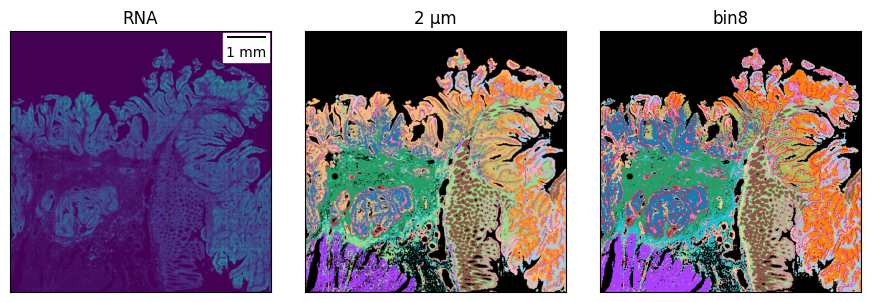

In [30]:
plot_ctmaps(ctmap, ctmap_16um, rna=kde)

And we can zoom-in in different regions to compare it.

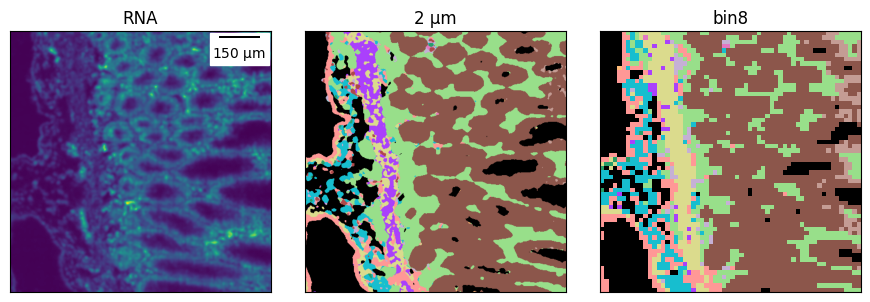

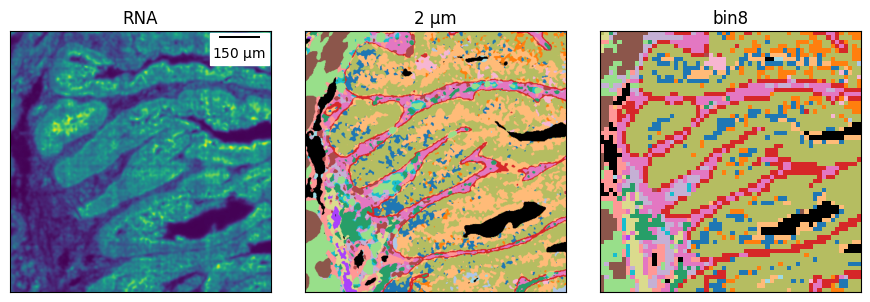

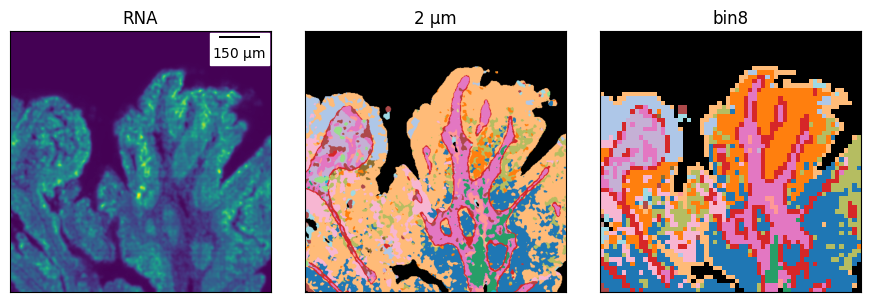

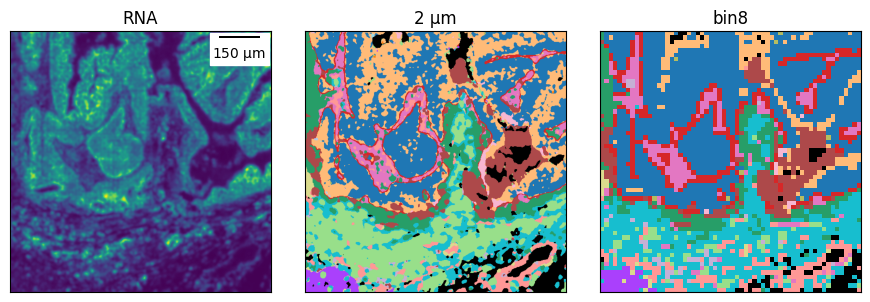

In [34]:
# the ROI boundaries are defined on the binned cell type map
rois = [
    ((220, 280), (20, 80)),
    ((260, 320), (200, 260)),
    ((80, 140), (270, 330)),
    ((70, 130), (70, 130)),
]

for roi in rois:
    plot_ctmaps(*subset_ctmaps(ctmap, ctmap_16um, *roi, rna=kde))